# Introduction

This notebook shows how to use AutoPeptideML from its Python interface. Please, look at the upper right corner of the notebook and click on the three dots that say Connect. From there choose the option to 'Change runtime' and select T4 GPU runtime to get GPU acceleration. Otherwise, the notebook might take longer.

### 1. Prepare environment

We start by setting up the environment by installing AutoPeptideML and its dependencies

In [ ]:
!pip install git+https://github.com/IBM/AutoPeptideML --quiet
!pip install smilespe --quiet

In [ ]:
!wget https://raw.githubusercontent.com/IBM/PeptideGeneralizationBenchmarks/refs/heads/main/downstream_data/nc-antiviral.csv
!wget https://raw.githubusercontent.com/IBM/PeptideGeneralizationBenchmarks/refs/heads/main/downstream_data/c-antiviral.csv

After this step the notebook might crash, that's fine, see instructions in the following cell

In [ ]:
!pip install numpy -U

The notebook might have crashed in the previous step, if so, please just continue executing from this cell on. Do not 'Run All', nor repeat the previous step as it will crash again.

### 2. Loading data and Initializing AutoPeptideML

First, take a look at the preprocessing pipelines that will be applied to the data.

The `to-smiles` pipeline takes peptide sequences and trasnforms them into canonical SMILES according to the RDKit algorithm.

The `to-sequences` pipeline takes peptide SMILES and transforms them into sequences of canonical amino acids. If a non-canonical amino acid was present in the sequence is transformed into its natural analog. If none is available it transforms it into the `X` residue.

In [1]:
from autopeptideml.pipeline import get_pipeline

to_smiles = get_pipeline('to-smiles')
print(to_smiles)

to-smiles
->  to-smiles-1
->  ->  to-smiles-1a
->  ->  ->  filter-smiles -> keep_smiles: False
->  ->  ->  canonical-cleaner -> substitution: G
->  ->  ->  sequence-to-smiles
->  ->  
->  ->  to-smiles-1b
->  ->  ->  filter-smiles -> keep_smiles: True
->  ->  
->  aggregate
->  canonicalize-smiles



In [2]:
to_sequences = get_pipeline('to-sequences')
print(to_sequences)

to-sequences
->  to-sequences-1
->  ->  to-sequences-1a
->  ->  ->  filter-smiles -> keep_smiles: False
->  ->  
->  ->  to-sequences-1b
->  ->  ->  filter-smiles -> keep_smiles: True
->  ->  ->  smiles-to-sequence
->  ->  
->  aggregate
->  canonical-cleaner -> substitution: X




We define the dataset that we are going to use to build our model. There are three options:

1. Training on natural (or canonical) peptides
2. Training on modified (or non-canonical) peptides
3. Training on a combination thereof

Uncomment the code from the option you're interested in trying

In [3]:
import pandas as pd
from autopeptideml import AutoPeptideML

# # Option 1 - Natural peptides
df = pd.read_csv('c-antiviral.csv')
df = df[df['labels'] == 1].sample(500, random_state=1)
db = 'canonical'
all_inputs = df['sequence'].tolist()

# # Option 2 - Modified peptides
# df2 = pd.read_csv('nc-antiviral.csv')
# df2 = df2[df2['labels'] == 1]
# db = 'non-canonical'
# all_inputs = df2['SMILES'].tolist()

# # Option 3 - Both
# df = pd.read_csv('c-antiviral.csv')
# df = df[df['labels'] == 1].sample(250, random_state=1)
# df2 = pd.read_csv('nc-antiviral.csv')
# df2 = df2[df2['labels'] == 1]
# db = 'both'
# all_inputs = df['sequence'].tolist() + df2['SMILES'].tolist()

# Initialise AutoPeptideML
apml = AutoPeptideML(
    data=all_inputs,
    outputdir='demo'
)

The original dataset does not have any negative peptides

In [4]:
# Check distribution of labels
apml.df.label.value_counts()

label
1    500
Name: count, dtype: int64

### 2. Automatic negative sampling

We sample the negative peptides from the dedicated database, with a proportion of negative/positive equal to `desired_ratio`.

In [5]:
# Sample negatives
apml.sample_negatives(
    target_db=db,
    activities_to_exclude='Antibacterial',
    desired_ratio=1.0,
    sample_by='mw',
    n_jobs=10
)

Executing preprocessing step 1 of 2: to-smiles-1
Executing preprocessing step 1 of 2: to-smiles-1a
Executing preprocessing step 1 of 3: filter-smiles


100%|██████████| 500/500 [00:00<00:00, 653kit/s]


Executing preprocessing step 2 of 3: canonical-cleaner


100%|██████████| 500/500 [00:00<00:00, 788kit/s]

Executing preprocessing step 3 of 3: sequence-to-smiles



100%|██████████| 500/500 [00:04<00:00, 116it/s]  


Executing preprocessing step 2 of 2: to-smiles-1b
Executing preprocessing step 1 of 1: filter-smiles


100%|██████████| 500/500 [00:00<00:00, 912kit/s]


Executing preprocessing step 2 of 2: canonicalize-smiles


100%|██████████| 500/500 [00:00<00:00, 789kit/s]


Executing preprocessing step 1 of 2: to-sequences-1
Executing preprocessing step 1 of 2: to-sequences-1a
Executing preprocessing step 1 of 1: filter-smiles


100%|██████████| 500/500 [00:00<00:00, 1.03Mit/s]


Executing preprocessing step 2 of 2: to-sequences-1b
Executing preprocessing step 1 of 2: filter-smiles


100%|██████████| 500/500 [00:00<00:00, 1.01Mit/s]


Executing preprocessing step 2 of 2: smiles-to-sequence
Executing preprocessing step 2 of 2: canonical-cleaner


100%|██████████| 500/500 [00:00<00:00, 880kit/s]


Check now the label distribution

label
1    500
0    500
Name: count, dtype: int64

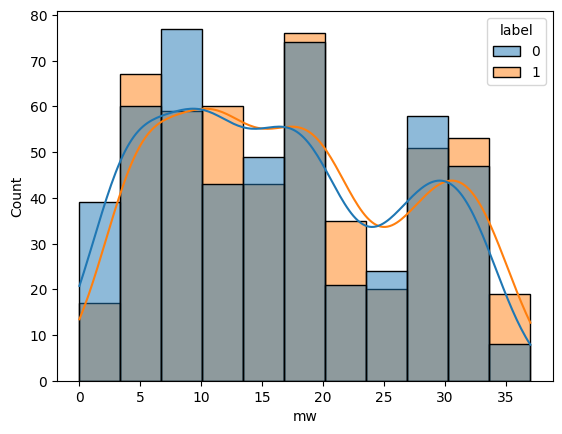

In [6]:
# Check distribution of labels after negative sampling
import seaborn as sns

sns.histplot(apml.df, x='mw', hue='label', kde=True, alpha=0.5)
apml.df.label.value_counts()

In [7]:
apml.df['apml-seqs'].isna().sum()

0

### 3. Build models

Here there are two parameters we can change:

1. `split-strategy`: it can be changed from `'min'` to `'random'`
2. `sim-args`: are usually defined by default, here we are gonna compare sequence similarity to fingerprint similarity
3. `reps`: select the method you would like to try

In [8]:
!pip install transformers --no-cache-dir --quiet -U

^C


In [11]:
# Build models
from hestia import SimArguments, HestiaGenerator

# Sim args - Option 1 - Fingerprint MAPc
sim_args_mapc = SimArguments(
    data_type='small molecule',
    field_name='apml-smiles',
    min_threshold=0.1,
    sim_function='jaccard',
    fingerprint='mapc',
    radius=4,
    bits=1024,
    verbose=3
)

# Sim args - Option 2 - Fingerprint ECFP
sim_args_ecfp = SimArguments(
    data_type='small molecule',
    field_name='apml-smiles',
    min_threshold=0.1,
    sim_function='tanimoto',
    fingerprint='ecfp',
    radius=4,
    bits=1024,
    verbose=3
)

# Sim args - Option 3 - Sequence similarity MMSeqs2
sim_args_seq = SimArguments(
    data_type='sequence',
    field_name='apml-seqs',
    min_threshold=0.1,
    alignment_algorithm='mmseqs',
    prefilter=True,
    denominator='n_aligned',
    verbose=3
)

apml.build_models(task='class',
                  reps=['ecfp', 'chemberta-2', 'esm2-8m'], # Options: chemberta-2, peptideclm, molformer, fcfp, esm2-8m
                  device='cuda', # Change to cuda if using hardware acceleartion
                  models=['svm', 'rf'], # Options: knn, svm, rf, xgboost, lightgbm 
                  split_strategy='min',
                  sim_args=sim_args_ecfp, # Options: sim_args_ecfp, sim_args_mapc, sim_args_
                  n_trials=50)

Partitioning...
Computing ecfp representations...


100%|██████████| 8/8 [00:01<00:00,  7.33it/s]


Computing chemberta-2 representations...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Computing esm2-8m representations...


100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from autopeptideml.utils.plots import plot_optimization_history

plot_optimization_history(apml.trainer.history)

In [ ]:
from autopeptideml.utils.plots import plot_model_vs_rep

plot_model_vs_rep(apml.trainer.history)

In [ ]:
apml._evaluating(task='class')
apml.test_result

In [ ]:
from os import path as osp

input_trial = {rep: apml.x[rep][:10] for rep in apml.trainer.best_model.reps}
preds = apml.trainer.best_model.predict(input_trial)

apml.trainer.best_model.save(osp.join(apml.outputdir, 'ensemble'))

In [ ]:
from autopeptideml.train.architectures import VotingEnsemble
ensemble = VotingEnsemble.load(osp.join(apml.outputdir, 'ensemble'))


preds = apml.trainer.best_model.predict(input_trial)[0]
preds2 = ensemble.predict(input_trial)[0]
